## Imports

In [36]:
import pandas as pd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Imports Bigquery
from google.cloud import bigquery
from google.oauth2 import service_account

## GCP config

In [2]:
#Localisation du projet name et table_id sur gcp
#TODO : Remplacer le nom du projet et du dataset sur GCP 
project="marbotic"
dataset = "marbotic_dataset"

In [3]:
#intégration des credentials
#TODO : Remplacer le path de credential d'accès à notre projet GCP
key_path = "/Users/antonin/code/AntoninAnq/gcp/marbotic-7d02fac30bd8.json"

credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],)

## Preprocessin du JSON

In [4]:
#conversion du fichier json en json line delimiter pour utiliser pd.read_json avec une chunk size. (Nombre de ligne processée en une fois)
#!cat ../raw_data/export_23-5_minified.json | jq -c '.[]' > ../raw_data/export_converted_2.json

## GCP upload table events

In [5]:
#TODO : Remplacer la localisation des données sources
FILE_PATH = '../raw_data/export_converted_2.json'

In [6]:
def upload_events_table(path,credentials, project,dataset,table):
    CHUNKSIZE = 100000
    table_id = f"{dataset}.{table}"
    df = pd.read_json(path, lines=True, chunksize=CHUNKSIZE) #Chunk size pour avoir 14 chunk
    
    client = bigquery.Client(project,credentials)
    
    for i,c in enumerate(df):
        index_init = np.linspace(1,len(c),len(c),dtype='int32')
        ep=pd.DataFrame()
        c.reset_index(inplace=True)
        ep=c.copy()
        ep.drop(['user_properties','event_properties'],axis=1,inplace=True)
        ep['user_id'] = ep['user_id'].apply(lambda x: 0 if (x is None or type(x)== str or  np.isnan(x)) else int(x))
        ep['id'] = (i*CHUNKSIZE) + index_init
        ep.drop(['index'],axis=1,inplace=True)
        #ep.to_csv('../raw_data/events.csv',index=False)
        job = client.load_table_from_dataframe(ep, table_id) 
        job.result()  # Wait for the job to complete.
        table = client.get_table(table_id)  # Make an API request.
        print(
            "Loaded {} rows and {} columns to {}".format(
                table.num_rows, len(table.schema), table_id
            )
        )

In [7]:
#TODO : Uncomment this line if you need to upload again events table
#upload_events_table(FILE_PATH,credentials, project,dataset,"events_f")

## GCP upload table user_id

In [8]:
#TODO : Remplacer la localisation des données sources
FILE_PATH_USER_ID = '../raw_data/users_info_202206071551.csv'

In [9]:
def upload_user_id_table(path,credentials, project,dataset,table):
    CHUNKSIZE = 5000
    
    table_id = f"{dataset}.{table}"
    df = pd.read_csv(path,chunksize=CHUNKSIZE,sep=";")
    client = bigquery.Client(project,credentials)
    
    for i,c in enumerate(df):
        ep=pd.DataFrame()
        c.reset_index(inplace=True)
        ep=c.copy()
        ep.drop(['Country','Language','News letter','Type','Games','Products','Pieces','index'],axis=1,inplace=True)
        ep.rename(columns={'User id':'User_id'},inplace=True)
    
        cat = ep['Purchases'].copy().map(lambda x: ", ".join(x)
                                            if isinstance(x, list) else x)
        names = list(
            set([
                x.strip().strip("'").strip("['")
                for x in ', '.join(', '.join(', '.join(
                    list(set([str(x) for x in cat]))).split('\n')).split(
                        "' '")).split(',')
            ]))
    
        names_transf = [
            'Purchases' + '_' + x.replace(' ', '_').replace(']', '').replace('"', '') for x in names
            if x != 'nan' and x != ''
        ]
        names = [x for x in names if x != 'nan' and x != '']
        for ind, name in enumerate(names_transf):
            ep[f'{name}'] = ep['Purchases'].map(
                lambda x: 1 if isinstance(x, str) and f'{names[ind]}' in x else
                (1 if isinstance(x, list) and
                 len([n for n in x if f'{names[ind]}' in n]) > 0
                 else 0))
            
        ep.drop(['Purchases'],axis=1,inplace=True)
            
        job = client.load_table_from_dataframe(ep, table_id)  
        job.result()  
        table = client.get_table(table_id)
        print(
            "Loaded {} rows and {} columns to {}".format(
                table.num_rows, len(table.schema), table_id
            )
        )

In [10]:
#TODO : Uncomment this line if you need to upload again user_id table
#upload_user_id_table(FILE_PATH_USER_ID,credentials, project,dataset,"user_id_f")

**Creation de la colonne purchases**

On créé une colonne "purchases" pour spécifier si l'utilisateur à déjà acheté au moins un produit.  
On le fait via la console GCP avec les commande SQL ci dessous.  

Dans un premier temps on doit créé la colonne "purchases" de type booléen qui sera vide.  
Puis on initialise toutes les valeurs à False avec la requête ci dessous.

```   
UPDATE `marbotic.marbotic_dataset.user_id_f`  
SET purchases = False  
WHERE TRUE  
```


Enfin on mets à jour les profils utilisateurs ayant effectué au moins un achat avec la requête ci dessous.  

```
UPDATE `marbotic.marbotic_dataset.user_id_f`   
SET purchases = True  
WHERE Purchases_PY1Y = 1  
OR  
Purchases_PLY = 1  
OR   
Purchases_MEGR = 1  
OR  
Purchases_PLM = 1  
OR   
Purchases_ME1 = 1  
OR   
Purchases_EY3M = 1  
OR  
Purchases_tier_upgrade_0_to_1 = 1  
OR  
Purchases_PM3M = 1  
OR  
Purchases_MPGR = 1  
OR  
Purchases_EY1Y = 1  
OR  
Purchases_PY3M = 1  
```

## GCP upload user_properties

In [11]:
def upload_user_properties_table(path,credentials, project,dataset,table):

    CHUNKSIZE = 100000
    table_id = f"{dataset}.{table}"
    df = pd.read_json(path, lines=True, chunksize=CHUNKSIZE) #Chunk size pour avoir 14 chunk
    
    client = bigquery.Client(project,credentials)
    
    for i,c in enumerate(df):
        index_init = np.linspace(1,len(c),len(c),dtype='int32')
        ep=pd.DataFrame()
        c.reset_index(inplace=True)
        ep=pd.DataFrame(c["user_properties"].to_list()).copy()
    
        for col_concat in ['Products', 'Pieces', 'Games']:
            cat = ep[f'{col_concat}'].copy().map(lambda x: ", ".join(x)
                                                if isinstance(x, list) else x)
            names = list(
                set([
                    x.strip().strip("'").strip("['")
                    for x in ', '.join(', '.join(', '.join(
                        list(set([str(x) for x in cat]))).split('\n')).split(
                            "' '")).split(',')
                ]))
            names_transf = [
                col_concat + '_' + x.replace(' ', '_') for x in names
                if x != 'nan' and x != ''
            ]
            names = [x for x in names if x != 'nan' and x != '']
            for ind, name in enumerate(names_transf):
    
                ep[f'{name}'] = ep[f'{col_concat}'].map(
                    lambda x: 1 if isinstance(x, str) and f'{names[ind]}' in x else
                    (1 if isinstance(x, list) and
                     len([n for n in x if f'{names[ind]}' in n]) > 0
                     else 0))
    
        ep.drop(['Products', 'Pieces', 'Games'], axis=1, inplace=True)
        ep['event_id']=c["event_id"].copy()
        ep['client_event_time']=c['client_event_time'].copy()
        ep['user_creation_time']=c['user_creation_time'].copy()
        ep['user_id']=c['user_id'].copy()
        ep['user_id'] = ep['user_id'].apply(lambda x: 0 if (x is None or type(x)== str or  np.isnan(x)) else int(x))
        ep['id'] = (i*CHUNKSIZE) + index_init
        
        job_config = bigquery.LoadJobConfig()
        job_config.write_disposition = bigquery.WriteDisposition.WRITE_APPEND
        job_config.schema_update_options = [
        bigquery.SchemaUpdateOption.ALLOW_FIELD_ADDITION
        ]
        
        job = client.load_table_from_dataframe(ep, table_id, job_config=job_config)
        job.result()  
        table = client.get_table(table_id)  
        print(
            "Loaded {} rows and {} columns to {}".format(
                table.num_rows, len(table.schema), table_id
            )
            )

In [12]:
#TODO : Uncomment this line if you need to upload again user_properties table
#upload_user_properties_table(FILE_PATH,credentials, project,dataset,"user_properties_f")

## GCP upload event_properties

In [13]:
#Update columns name for big query acceptance
columns_rename = {'[Game] Code':'Game_Code','[Profile] Age (days)':'Profile_Age_days','[Scene] Name':'Scene_Name',
                 '[Game] Language':'Game_Language', '[Scene] Previous':'Scene_Previous', '[Time] Spent':'Time_Spent',
                  '[Scene] Next':'Scene_Next', '[Action] Element Type':'Action_Element_Type',
                  '[Scene] Section':'Scene_Section', '[Action] Element Name':'Action_Element_Name',
                 '[Activity] Name':'Activity_Name', '[Scaffolding] Level':'Scaffolding_Level',
                  '[Game] Piece Code':'Game_Piece_Code','[Activity] Nb Wrong Answer':'Activity_Nb_Wrong_Answer',
                  '[Activity] Solved':'Activity_Solved','[Activity] Piece Stamped':'Activity_Piece_Stamped',
                  '[Activity] Piece Asked':'Activity_Piece_Asked','[Activity] Modality':'Activity_Modality',
                  '[Time] Slot':'Time_Slot', '[Error] Type':'Error_Type',
                  '[Activation] Game Code':'Activation_Game_Code',
                  '[Activation] Product Code':'Activation_Product_Code',
                 '[Activation] Piece Code':'Activation_Piece_Code', '[Popup] Name':'Popup_Name',
                  '[Renewal] Type':'Renewal_Type','[Key] Type':'Key_Type','[Toast] Name':'Toast_Name'}

In [14]:
def upload_event_properties_table(path,credentials, project,dataset,table):
    CHUNKSIZE = 100000
    
    table_id = f"{dataset}.{table}"
    df = pd.read_json(path, lines=True, chunksize=CHUNKSIZE) #Chunk size pour avoir 14 chunk
    
    client = bigquery.Client(project,credentials)
    
    for i,c in enumerate(df):
        index_init = np.linspace(1,len(c),len(c),dtype='int32')
        ep=pd.DataFrame()
        c.reset_index(inplace=True)
        ep=pd.DataFrame(c["event_properties"].to_list()).copy()
        ep['event_id']=c["event_id"].copy()
        ep['event_type']=c["event_type"].copy()
        ep['session_id']=c["session_id"].copy()
        ep['id'] = (i*CHUNKSIZE) + index_init
        ep.rename(columns=columns_rename,inplace=True)
        #ep.to_csv('../raw_data/event_properties.csv',index=False)
        
        job_config = bigquery.LoadJobConfig()
        job_config.write_disposition = bigquery.WriteDisposition.WRITE_APPEND
        job_config.schema_update_options = [
        bigquery.SchemaUpdateOption.ALLOW_FIELD_ADDITION
        ]
        
        job = client.load_table_from_dataframe(ep, table_id,job_config=job_config)  
        job.result()  
        table = client.get_table(table_id) 
        print(
            "Loaded {} rows and {} columns to {}".format(
                table.num_rows, len(table.schema), table_id
            )
        )  

In [15]:
#TODO : Uncomment this line if you need to upload again event_properties table
#upload_event_properties_table(FILE_PATH,credentials, project,dataset,"event_properties_f")

## Retrieve event table and prepare for aggregations - users metrics table creation

In [16]:
def extract_event(project,dataset,credentials,table):
    '''Extracting events table'''
    client = bigquery.Client(project, credentials=credentials)

    query = f"""SELECT * FROM {project}.{dataset}.{table}"""

    query_job = client.query(query)  # Make an API request.
    results=query_job.result().to_dataframe() # Waits for job to complete.

    return pd.DataFrame(results)

In [21]:
data = extract_event(project,dataset,credentials,"events")

In [23]:
# Remove duplicates
df = data.drop_duplicates()

In [24]:
#trouver la proportion de lignes nulles en% 
df.isnull().sum().sort_values(ascending = False)/len(data)*100

city                    1.089735
region                  0.910069
client_event_time       0.000000
country                 0.000000
device_model            0.000000
event_id                0.000000
event_type              0.000000
is_attribution_event    0.000000
language                0.000000
os_version              0.000000
session_id              0.000000
start_version           0.000000
user_creation_time      0.000000
user_id                 0.000000
id                      0.000000
dtype: float64

In [25]:
#drop lines with user_id equal to zero
df = df[df.user_id != 0].copy()

In [26]:
#replace by no_region if no region
df.region.replace(np.nan, "no_region", inplace=True) 

#replace by no_city if no city
df.city.replace(np.nan, "no_city", inplace=True) 

In [27]:
df.isnull().sum().sort_values(ascending = False)

city                    0
client_event_time       0
country                 0
device_model            0
event_id                0
event_type              0
is_attribution_event    0
language                0
os_version              0
region                  0
session_id              0
start_version           0
user_creation_time      0
user_id                 0
id                      0
dtype: int64

In [28]:
event_type_list = list(df.event_type.unique())

In [29]:
dict_event_simple = {'[Profile] Create' : "setup" ,                     
         '[Profile] Update' : "setup",                     
         '[Account] Sign In' : "setup",                    
         '[OB] ProfileName' : "setup",                     
         '[OB] ProfileBirthdate' : "setup",                    
         '[Activation] Game' : "game",                    
         '[OB] KeyRedeem' : "setup",                     
         '[OB] KeyFail' : "setup",                     
         '[OB] RenewalSelection' : "setup",                    
         '[Account] Sign Up' : "setup",                     
         '[OB] ProductSelection' : "setup",                    
         '[OB] ProductSK' : "setup",                    
         '[OB] ProductHelp' : "setup",                     
         '[OB] ProductActivation' : "setup",                     
         '[Game] Stop' : "game",
         '[OB] RenewalSuccess' : "setup",                     
         '[OB] ProductSeeMore' : "setup",                     
         '[OB] ProductOther' : "setup",                    
         '[Scaffolding] Reset' : "game",                    
         '[Account] Sign Out' : "setup",                     
         '[OB] CommPreview' : "setup",                    
         '[OB] DoYouHaveKit' : "setup",                    
         '[OB] HasKitYes' : "setup",                     
         '[OB] Email' : "setup",                    
         '[OB] VerifCode' : "setup",                     
         '[Activation] New Activation' : "setup",
         '[Activation] Product' : "setup",                     
         '[Activation] Piece' : "setup",                     
         '[OB] Success' : "setup",                    
         '[OB] RenewalFail' : "setup",                     
         '[OB] ClickTrial' : "setup",                     
         '[Popup] Open' : "setup",                    
         '[Popup] Close' : "setup",                   
         '[OB] HasKitNo' : "setup",                    
         '[OB] DiscoverTrial' : "setup",                    
         '[Account] Update Request' : "setup",                     
         '[Account] Update Success' : "setup",                    
         '[Profile] Delete' : "setup",                     
         '[OB] TrialStart' : "setup",                     
         '[OB] ClickStore' : "setup",                    
         '[OB] HasKeyNo' : "setup",                     
         '[OB] Type' : "setup",                     
         '[OB] KeySuccess' : "setup",                     
         '[Game] Pause' : "game",                    
         '[Game] Start' : "game",                    
         '[Error] Error' : "game",                     
         '[Scene] Enter' : "game",                     
         '[Scene] Leave' : "game",                    
         '[Action] Click' : "game",
         '[Activity] Stop' : "game", 
         '[Activity] Start' : "game",
         '[Activity] Good Answer' : "game", 
         '[Activity] Wrong Answer' : "game",
         '[Scaffolding] Scaffolding' : "game",                    
         '[Profile] Reset Settings and Progression' : "setup"}    

In [30]:
for el in event_type_list:
    if el not in list(dict_event_simple.keys()):        
        dict_event_simple[el] = "TO_BE_CHANGED"
        
dict_event_simple['[Toast] Appear'] = 'setup'
dict_event_simple['[Toast] Disappear'] = 'setup'
dict_event_simple['[Action] ConversionClickSubscribe'] = 'setup'
dict_event_simple['[Action] ConversionClickRedeem'] = 'setup'

In [31]:
df["event_simple"]=df["event_type"].map(dict_event_simple)

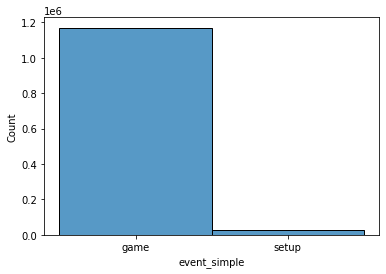

In [34]:
sns.histplot(data=df, x="event_simple");

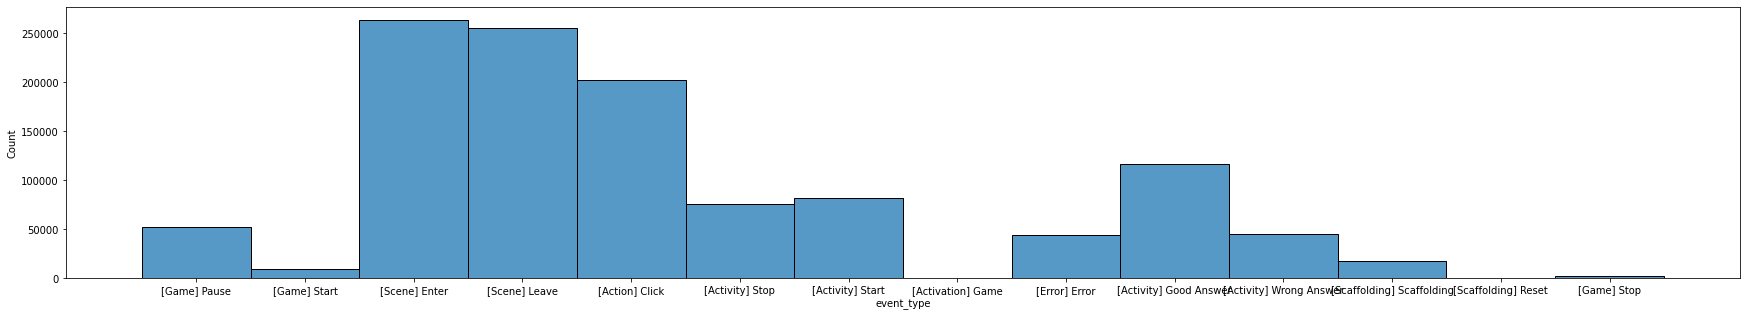

In [37]:
plt.figure(figsize=(30,5))

sns.histplot(data=df[df['event_simple']=='game'], x="event_type");

In [38]:
df[df['event_simple']=='game'].nunique()

city                       1749
client_event_time       1161188
country                      74
device_model                 33
event_id                  35272
event_type                   14
is_attribution_event          1
language                     16
os_version                   72
region                      395
session_id                18814
start_version                54
user_creation_time         2624
user_id                    2624
id                      1169806
event_simple                  1
dtype: int64

### Create user_metrics derivative table and upload to GBQ

In [39]:
#calculate game intensity metrics by player
#step 1 : one hot encode game feature
from sklearn.preprocessing import OneHotEncoder

# Instantiate encoder
ohe = OneHotEncoder(sparse = False) 

# Fit encoder all 55 features, not great (i want to use it only for the gaming events, but hey, you got what you got
ohe.fit(df[['event_type']]) 

# Encode + retrieve columns names
df_encoded = ohe.transform(df[['event_type']]) 
df_encoded = pd.DataFrame(df_encoded)

df_encoded.columns = ohe.get_feature_names_out()

In [40]:
df_final = pd.concat([df,df_encoded],axis=1)

In [47]:
# Renames columns to get rid of [] and avoid issues with Google big query upload later on
for col in list(df_final.columns):
    col_new = col.replace("[","").replace("]","").replace(" ","_")
    if col_new != col: 
        df_final[col_new] = df_final[col]
        del df_final[col]
df_final

,city,client_event_time,country,device_model,event_id,event_type,is_attribution_event,language,os_version,region,...,event_type_Profile_Create,event_type_Profile_Delete,event_type_Profile_Reset_Settings_and_Progression,event_type_Profile_Update,event_type_Scaffolding_Reset,event_type_Scaffolding_Scaffolding,event_type_Scene_Enter,event_type_Scene_Leave,event_type_Toast_Appear,event_type_Toast_Disappear
0,Newcastle upon Tyne,2022-03-05 16:21:14.284000+00:00,United Kingdom,"iPad13,10",148.0,[Game] Pause,False,English,15.2.1,Newcastle upon Tyne,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Newcastle upon Tyne,2022-03-05 16:21:50.233000+00:00,United Kingdom,"iPad13,10",154.0,[Game] Pause,False,English,15.2.1,Newcastle upon Tyne,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Newcastle upon Tyne,2022-03-05 16:13:58.157000+00:00,United Kingdom,"iPad13,10",97.0,[Game] Start,False,English,15.2.1,Newcastle upon Tyne,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Newcastle upon Tyne,2022-03-05 16:18:32.980000+00:00,United Kingdom,"iPad13,10",109.0,[Scene] Enter,False,English,15.2.1,Newcastle upon Tyne,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,Newcastle upon Tyne,2022-03-05 16:18:33.329000+00:00,United Kingdom,"iPad13,10",112.0,[Scene] Enter,False,English,15.2.1,Newcastle upon Tyne,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1194627,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1194699,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1194759,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1194854,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [48]:
# Group by user_id and add the count of nb of unique session, nb of unique event recorded for one user
user_base = pd.DataFrame(df_final.groupby("user_id").max()["user_creation_time"])
user_base

for col in ['id','session_id']:
    col_series = df_final.groupby("user_id").nunique()[col]
    user_base = pd.merge(user_base.copy(), col_series, on="user_id", how="left")

user_base

,user_creation_time,id,session_id
user_id,,,
211.0,2022-02-27 13:34:22.901000+00:00,824,8
274.0,2020-09-18 17:14:30.805000+00:00,40,7
453.0,2021-11-01 23:55:04.177000+00:00,153,3
564.0,2021-01-01 20:29:36.330000+00:00,52,1
609.0,2020-10-27 15:15:40.936000+00:00,69,1
...,...,...,...
73184.0,2022-05-12 16:20:23.231000+00:00,81,1
73185.0,2022-05-12 16:30:57.876000+00:00,122,1
73188.0,2022-05-12 21:02:44.492000+00:00,219,1


In [49]:
# Group by user_id and add the count of event_type : number of event register by event_type for one user
list_event = [col for col in list(df_final.columns) if col[:11] == "event_type_"]

list_event

for col in list_event:
    col_series = df_final.groupby("user_id").sum()[col]
    user_base = pd.merge(user_base.copy(), col_series, on="user_id", how="left")

user_base

,user_creation_time,id,session_id,event_type_Account_Sign_In,event_type_Account_Sign_Out,event_type_Account_Sign_Up,event_type_Account_Update_Request,event_type_Account_Update_Success,event_type_Action_Click,event_type_Action_ConversionClickRedeem,...,event_type_Profile_Create,event_type_Profile_Delete,event_type_Profile_Reset_Settings_and_Progression,event_type_Profile_Update,event_type_Scaffolding_Reset,event_type_Scaffolding_Scaffolding,event_type_Scene_Enter,event_type_Scene_Leave,event_type_Toast_Appear,event_type_Toast_Disappear
user_id,,,,,,,,,,,,,,,,,,,,,
211.0,2022-02-27 13:34:22.901000+00:00,824,8,0.0,0.0,0.0,0.0,0.0,250.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,356.0,0.0,0.0
274.0,2020-09-18 17:14:30.805000+00:00,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
453.0,2021-11-01 23:55:04.177000+00:00,153,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,109.0,0.0,0.0,0.0
564.0,2021-01-01 20:29:36.330000+00:00,52,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,20.0,0.0,0.0
609.0,2020-10-27 15:15:40.936000+00:00,69,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,23.0,24.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73184.0,2022-05-12 16:20:23.231000+00:00,81,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0,0.0,0.0
73185.0,2022-05-12 16:30:57.876000+00:00,122,1,1.0,0.0,0.0,1.0,1.0,37.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0
73188.0,2022-05-12 21:02:44.492000+00:00,219,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
# Group by customerID and select only the information for the last timestamp
grouping =df_final.loc[df_final.groupby("user_id")["client_event_time"].idxmax()]
grouping = grouping[['user_id','client_event_time','city','language','os_version','region','country','device_model','start_version']]
grouping = grouping.merge(user_base,on="user_id",how='inner')
grouping

,user_id,client_event_time,city,language,os_version,region,country,device_model,start_version,user_creation_time,...,event_type_Profile_Create,event_type_Profile_Delete,event_type_Profile_Reset_Settings_and_Progression,event_type_Profile_Update,event_type_Scaffolding_Reset,event_type_Scaffolding_Scaffolding,event_type_Scene_Enter,event_type_Scene_Leave,event_type_Toast_Appear,event_type_Toast_Disappear
0,211.0,2022-03-13 13:32:14.916000+00:00,Norwich,English,14.7.1,Norfolk,United Kingdom,iPad 5,1.0.8,2022-02-27 13:34:22.901000+00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,356.0,0.0,0.0
1,274.0,2022-05-01 17:44:50.615000+00:00,Columbus,English,14.7.1,Ohio,United States,"iPad11,6",1.2.1,2020-09-18 17:14:30.805000+00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
2,453.0,2022-03-19 21:37:36.833000+00:00,Livermore,English,12.5.5,California,United States,iPad Air,1.3.0,2021-11-01 23:55:04.177000+00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,109.0,0.0,0.0,0.0
3,564.0,2022-04-23 15:37:54.445000+00:00,Carson City,English,14.8,Nevada,United States,iPad Air 2,1.0.1,2021-01-01 20:29:36.330000+00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,20.0,0.0,0.0
4,609.0,2022-05-07 16:33:03.540000+00:00,Westminster,English,15.4.1,Maryland,United States,iPad 6,2.1.0,2020-10-27 15:15:40.936000+00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,23.0,24.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2621,73184.0,2022-05-12 16:33:26.489000+00:00,Saint-Eustache,French,15.3.1,Quebec,Canada,iPad 5,2.0.6,2022-05-12 16:20:23.231000+00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0,0.0,0.0
2622,73185.0,2022-05-12 17:04:58.087000+00:00,Thunder Bay,English,14.7.1,Ontario,Canada,iPad Air 2,2.0.6,2022-05-12 16:30:57.876000+00:00,...,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0
2623,73188.0,2022-05-12 23:13:13.334000+00:00,Seattle,English,13.4.1,Washington,United States,iPad Air 3,2.0.6,2022-05-12 21:02:44.492000+00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2624,73197.0,2022-05-13 09:25:19.784000+00:00,Deinze,Dutch,15.4,East Flanders Province,Belgium,iPad Pro,2.0.6,2022-05-13 09:21:35.633000+00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0


### Uploading users metrics in big query

In [61]:
#Localisation du projet name et table_id sur gcp

def upload_df(dataframe_to_uploade,credentials, project,dataset,table):
    table_id = f"{dataset}.{table}"

    client = bigquery.Client(project,credentials)
    
    job = client.load_table_from_dataframe(dataframe_to_uploade, table_id) 
    
    job.result()  
    table = client.get_table(table_id) 
    print("Loaded {} rows and {} columns to {}".format(table.num_rows, len(table.schema), table_id))

In [54]:
# TODO : Uncomment if you need to upload users_metrics
#upload_df(grouping,credentials, project,dataset,"users_metrics_f")

Loaded 2626 rows and 71 columns to marbotic_dataset.users_metrics_f


## Create session_metrics derivative table and upload to GBQ

In [55]:
#creating session derivative table

#add session end timestamp

session_base = pd.DataFrame(df_final.groupby("session_id").max()["client_event_time"]) #prendre le timestamp de fin de session
session_base

col_series = df_final.groupby("session_id").nunique()['id']   #compter le nb d'evenement par session
session_base = pd.merge(session_base.copy(), col_series, on="session_id", how="left")

add_user_id = pd.DataFrame(df_final.groupby("session_id").max()["user_id"]) #prendre le user_id qui correspond à la session
session_base = pd.merge(session_base.copy(), add_user_id, on="session_id", how="left")

session_base

,client_event_time,id,user_id
session_id,,,
1.641524e+12,2022-01-07 02:56:29.983000+00:00,2,67750.0
1.641826e+12,2022-01-10 15:05:31.598000+00:00,1,55884.0
1.641931e+12,2022-01-11 20:00:30.512000+00:00,97,65632.0
1.641932e+12,2022-01-11 20:06:04.323000+00:00,2,65632.0
1.642001e+12,2022-01-12 15:34:25.246000+00:00,5,66337.0
...,...,...,...
1.652434e+12,2022-05-13 09:52:12.279000+00:00,26,65663.0
1.652434e+12,2022-05-13 09:52:15.555000+00:00,28,65663.0
1.652435e+12,2022-05-13 09:55:59.033000+00:00,24,73198.0


In [56]:
#add individual OHE events counts

for col in list_event:
    col_series = df_final.groupby("session_id").sum()[col]  #compte les evenements par session, une colonne = 1 event_type
    session_base = pd.merge(session_base.copy(), col_series, on="session_id", how="left")

session_base

,client_event_time,id,user_id,event_type_Account_Sign_In,event_type_Account_Sign_Out,event_type_Account_Sign_Up,event_type_Account_Update_Request,event_type_Account_Update_Success,event_type_Action_Click,event_type_Action_ConversionClickRedeem,...,event_type_Profile_Create,event_type_Profile_Delete,event_type_Profile_Reset_Settings_and_Progression,event_type_Profile_Update,event_type_Scaffolding_Reset,event_type_Scaffolding_Scaffolding,event_type_Scene_Enter,event_type_Scene_Leave,event_type_Toast_Appear,event_type_Toast_Disappear
session_id,,,,,,,,,,,,,,,,,,,,,
1.641524e+12,2022-01-07 02:56:29.983000+00:00,2,67750.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1.641826e+12,2022-01-10 15:05:31.598000+00:00,1,55884.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.641931e+12,2022-01-11 20:00:30.512000+00:00,97,65632.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,32.0,34.0,0.0,0.0
1.641932e+12,2022-01-11 20:06:04.323000+00:00,2,65632.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
1.642001e+12,2022-01-12 15:34:25.246000+00:00,5,66337.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.652434e+12,2022-05-13 09:52:12.279000+00:00,26,65663.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,12.0,0.0,0.0
1.652434e+12,2022-05-13 09:52:15.555000+00:00,28,65663.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,12.0,0.0,0.0
1.652435e+12,2022-05-13 09:55:59.033000+00:00,24,73198.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,15.0,5.0,0.0,0.0


In [57]:
# Group by customerID and select only the information for the last timestamp : prendre la derniere version
grouping =df_final.loc[df_final.groupby("session_id")["client_event_time"].idxmax()]
grouping = grouping[['session_id','city','language','os_version','region','country','device_model','start_version']]
session_base = grouping.merge(session_base.copy(),on="session_id",how='inner')
session_base

,session_id,city,language,os_version,region,country,device_model,start_version,client_event_time,id,...,event_type_Profile_Create,event_type_Profile_Delete,event_type_Profile_Reset_Settings_and_Progression,event_type_Profile_Update,event_type_Scaffolding_Reset,event_type_Scaffolding_Scaffolding,event_type_Scene_Enter,event_type_Scene_Leave,event_type_Toast_Appear,event_type_Toast_Disappear
0,1.641524e+12,Eugene,English,15.2,Oregon,United States,iPad Pro,1.0.7,2022-01-07 02:56:29.983000+00:00,2,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.641826e+12,Lithonia,English,12.5.5,Georgia,United States,iPad Mini 2,1.2.0,2022-01-10 15:05:31.598000+00:00,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.641931e+12,Oakville,English,13.5.1,Ontario,Canada,iPad Air 2,1.0.1,2022-01-11 20:00:30.512000+00:00,97,...,0.0,0.0,0.0,0.0,0.0,0.0,32.0,34.0,0.0,0.0
3,1.641932e+12,Oakville,English,13.5.1,Ontario,Canada,iPad Air 2,1.0.1,2022-01-11 20:06:04.323000+00:00,2,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
4,1.642001e+12,Parignargues,French,15.2,Gard,France,iPad 6,1.0.3,2022-01-12 15:34:25.246000+00:00,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18811,1.652434e+12,Montreal,French,10.3.3,Aude,France,iPad 4,1.0.1,2022-05-13 09:52:12.279000+00:00,26,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,12.0,0.0,0.0
18812,1.652434e+12,Montreal,French,10.3.3,Aude,France,iPad 4,1.0.1,2022-05-13 09:52:15.555000+00:00,28,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,12.0,0.0,0.0
18813,1.652435e+12,Medina,English,15.4.1,Medina Region,Saudi Arabia,"iPad12,1",2.0.6,2022-05-13 09:55:59.033000+00:00,24,...,0.0,0.0,0.0,0.0,0.0,0.0,15.0,5.0,0.0,0.0
18814,1.652435e+12,Melbourne,Chinese,12.5.5,Victoria,Australia,iPad Air,2.0.5,2022-05-13 09:58:43.012000+00:00,39,...,0.0,0.0,0.0,0.0,0.0,0.0,7.0,32.0,0.0,0.0


In [58]:
init_session = pd.DataFrame(df_final.groupby("session_id").min()["client_event_time"])#prendre le 1e ts de la session = start
init_session

session_base = pd.merge(session_base.copy(), init_session, on="session_id", how="left")

session_base

,session_id,city,language,os_version,region,country,device_model,start_version,client_event_time_x,id,...,event_type_Profile_Delete,event_type_Profile_Reset_Settings_and_Progression,event_type_Profile_Update,event_type_Scaffolding_Reset,event_type_Scaffolding_Scaffolding,event_type_Scene_Enter,event_type_Scene_Leave,event_type_Toast_Appear,event_type_Toast_Disappear,client_event_time_y
0,1.641524e+12,Eugene,English,15.2,Oregon,United States,iPad Pro,1.0.7,2022-01-07 02:56:29.983000+00:00,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2022-01-07 02:56:28.793000+00:00
1,1.641826e+12,Lithonia,English,12.5.5,Georgia,United States,iPad Mini 2,1.2.0,2022-01-10 15:05:31.598000+00:00,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-01-10 15:05:31.598000+00:00
2,1.641931e+12,Oakville,English,13.5.1,Ontario,Canada,iPad Air 2,1.0.1,2022-01-11 20:00:30.512000+00:00,97,...,0.0,0.0,0.0,0.0,0.0,32.0,34.0,0.0,0.0,2022-01-11 19:49:46.744000+00:00
3,1.641932e+12,Oakville,English,13.5.1,Ontario,Canada,iPad Air 2,1.0.1,2022-01-11 20:06:04.323000+00:00,2,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2022-01-11 20:06:03.428000+00:00
4,1.642001e+12,Parignargues,French,15.2,Gard,France,iPad 6,1.0.3,2022-01-12 15:34:25.246000+00:00,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-01-12 15:34:18.911000+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18811,1.652434e+12,Montreal,French,10.3.3,Aude,France,iPad 4,1.0.1,2022-05-13 09:52:12.279000+00:00,26,...,0.0,0.0,0.0,0.0,0.0,8.0,12.0,0.0,0.0,2022-05-13 09:31:25.198000+00:00
18812,1.652434e+12,Montreal,French,10.3.3,Aude,France,iPad 4,1.0.1,2022-05-13 09:52:15.555000+00:00,28,...,0.0,0.0,0.0,0.0,0.0,8.0,12.0,0.0,0.0,2022-05-13 09:31:39.459000+00:00
18813,1.652435e+12,Medina,English,15.4.1,Medina Region,Saudi Arabia,"iPad12,1",2.0.6,2022-05-13 09:55:59.033000+00:00,24,...,0.0,0.0,0.0,0.0,0.0,15.0,5.0,0.0,0.0,2022-05-13 09:51:46.132000+00:00
18814,1.652435e+12,Melbourne,Chinese,12.5.5,Victoria,Australia,iPad Air,2.0.5,2022-05-13 09:58:43.012000+00:00,39,...,0.0,0.0,0.0,0.0,0.0,7.0,32.0,0.0,0.0,2022-05-13 09:45:31.947000+00:00


In [59]:
session_base.rename(columns ={"client_event_time_y": "session_start","client_event_time_x" :"session_end"}, inplace = True)
session_base

,session_id,city,language,os_version,region,country,device_model,start_version,session_end,id,...,event_type_Profile_Delete,event_type_Profile_Reset_Settings_and_Progression,event_type_Profile_Update,event_type_Scaffolding_Reset,event_type_Scaffolding_Scaffolding,event_type_Scene_Enter,event_type_Scene_Leave,event_type_Toast_Appear,event_type_Toast_Disappear,session_start
0,1.641524e+12,Eugene,English,15.2,Oregon,United States,iPad Pro,1.0.7,2022-01-07 02:56:29.983000+00:00,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2022-01-07 02:56:28.793000+00:00
1,1.641826e+12,Lithonia,English,12.5.5,Georgia,United States,iPad Mini 2,1.2.0,2022-01-10 15:05:31.598000+00:00,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-01-10 15:05:31.598000+00:00
2,1.641931e+12,Oakville,English,13.5.1,Ontario,Canada,iPad Air 2,1.0.1,2022-01-11 20:00:30.512000+00:00,97,...,0.0,0.0,0.0,0.0,0.0,32.0,34.0,0.0,0.0,2022-01-11 19:49:46.744000+00:00
3,1.641932e+12,Oakville,English,13.5.1,Ontario,Canada,iPad Air 2,1.0.1,2022-01-11 20:06:04.323000+00:00,2,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2022-01-11 20:06:03.428000+00:00
4,1.642001e+12,Parignargues,French,15.2,Gard,France,iPad 6,1.0.3,2022-01-12 15:34:25.246000+00:00,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-01-12 15:34:18.911000+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18811,1.652434e+12,Montreal,French,10.3.3,Aude,France,iPad 4,1.0.1,2022-05-13 09:52:12.279000+00:00,26,...,0.0,0.0,0.0,0.0,0.0,8.0,12.0,0.0,0.0,2022-05-13 09:31:25.198000+00:00
18812,1.652434e+12,Montreal,French,10.3.3,Aude,France,iPad 4,1.0.1,2022-05-13 09:52:15.555000+00:00,28,...,0.0,0.0,0.0,0.0,0.0,8.0,12.0,0.0,0.0,2022-05-13 09:31:39.459000+00:00
18813,1.652435e+12,Medina,English,15.4.1,Medina Region,Saudi Arabia,"iPad12,1",2.0.6,2022-05-13 09:55:59.033000+00:00,24,...,0.0,0.0,0.0,0.0,0.0,15.0,5.0,0.0,0.0,2022-05-13 09:51:46.132000+00:00
18814,1.652435e+12,Melbourne,Chinese,12.5.5,Victoria,Australia,iPad Air,2.0.5,2022-05-13 09:58:43.012000+00:00,39,...,0.0,0.0,0.0,0.0,0.0,7.0,32.0,0.0,0.0,2022-05-13 09:45:31.947000+00:00


### Upload session_metrics in big query

In [63]:
#TODO : Uncomment if you need to upload the table
#upload_df(session_base,credentials, project,dataset,"session_metrics_f")